# Interrupted Timeseries Analysis after the Death of George Floyd
J. Nathan Matias

During the period from 2014-15 in the United States through 2022-2023:

* At a national level, starting in the year after the murder of George Floyd (2020-2021 academic year), was there an increase in the number or rate of change in the number and percentage of URM tenure track faculty? The expected mechanisms would be:
  * Greater awareness of inequality leading to different decisions from hiring committees
  * Public commitments from universities to hire URM faculty
* Within universities, after the murder of George Floyd, was there an increase in the number or rate of change in the number and percentage of URM tenure track faculty?
  * Within MSIs
  * Within HBCUs
  * Within Within IVY+ Universities
  * Within R1s in different US News regions?
  
Further considerations:
* Any hiring decisions made in 2020-2021 would only appear in the 2021-2022 year, since faculty do not show up on campus at the earliest until the year after they are hired.
* Do institutions vary by important covariates (TODO: decide):
  * The proportion of URM students at the institution (could generate)
  * The proportion of URM people in the population of US News region, as measured by the census (could research how to generate)
  * The difference in percentage betwen URM faculty and students (could generate)
  * The difference in the percentage between URM students and the population (could generate)
  * Whether the institution announced the creation of some kind of diversity or racial justice program (need to research)
  * Number of DEI staff in 2019 ([potential source: Heritage Foundation](https://www.heritage.org/education/report/diversity-university-dei-bloat-the-academy)) (could merge for the institutions considered by the Heritage Foundation, which is a particular sample of state institutions; or could reproduce the technique)

#### Inclusion Criteria
* Did a given institution have any tenured or tenure track faculty at any time in the observation period?

#### Context and Possible Confounding Factors
* What was the trend in total tenured faculty in the period?
* What was the trend in total un-tenured TT faculty in the period?
* Enrollment cliff
* Anticipated retirement of boomer faculty
* Closure of small colleges

#### Question
* We could compute a measure, based on enrollment data, on the probability of a URM studnt 


## Next Steps:
* OPTION A: 
    * Compute the Interrupted Timeseries for each institution individually
    * Then do an analysis of the differences in estimates, along with plots
* Option B:
    * Use a random intercepts model and test different hypotheses about the group-level intercepts

<!--References:
* [Data preparation code](https://github.com/natematias/ipeds-data-analysis)-->


In [1]:
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/4.3/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)
library(MASS) # includes CrossTable, should we need it
library(lme4)     # random intercepts
library(lmerTest) # random intercepts significance testing#
#library(plm)       # fixed effects models
library(stringr)
library(grid)
library(gridExtra) #arrange charts in a grid layout
library(fs)
library(gmodels) # contains CrossTable
library(xtable)
library(readxl)
library(english)
library(stargazer)

#color-blind palette
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
safe_colorblind_palette <- c("#88CCEE", "#CC6677", "#DDCC77", "#117733", "#332288", "#AA4499", 
                             "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")


## critical value for calculating 95% confidence intervals
critval = 1.96

Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




In [3]:
data.path = "/Users/nathan/Library/CloudStorage/Box-Box/Projects/"
nces.path = "2021-NCES-Faculty-Data/"
nsed.path = "2021-NSF-Survey-Earned-Doctorates/"

## this generation date includes 2020-2021 
#generation.date = "20240504"
generation.date = "20240301"

year.df   <- read.csv(paste(data.path, nces.path, generation.date, "_year_summary_table.csv", sep=""),na.strings = "")
all.df    <- read.csv(paste(data.path, nces.path, generation.date, "_all_institution_records.csv", sep=""),na.strings = "")

image.dir <- "../figures/"


In [4]:
## convert year into an integer
all.df$year <- as.integer(str_sub(all.df$year,0,4))
summary(all.df$year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2004    2009    2013    2013    2018    2022 

In [5]:
## generate percentage of tenured / un-tenured black, latino, american indian, alaska native

year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum <- 
    year.df$tenured_un_tenured_American_Indian_or_Alaska_Native_total_sum +
    year.df$tenured_un_tenured_Black_or_African_American_total_sum +
    year.df$tenured_un_tenured_Hispanic_or_Latino_total_sum +
    year.df$tenured_un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_sum +
    year.df$tenured_un_tenured_Two_or_more_races_total_sum

year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct <- 
    year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum / 
    year.df$tenured_un_tenured_Grand_total_sum

## un-tenured sum, used in the pipeline calculation
year.df$un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum <- 
    year.df$un_tenured_American_Indian_or_Alaska_Native_total_sum +
    year.df$un_tenured_Black_or_African_American_total_sum +
    year.df$un_tenured_Hispanic_or_Latino_total_sum +
    year.df$un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_sum +
    year.df$un_tenured_Two_or_more_races_total_sum

## un-tenured pct
year.df$un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct <- 
    year.df$un_tenured_American_Indian_or_Alaska_Native_total_pct +
    year.df$un_tenured_Black_or_African_American_total_pct +
    year.df$un_tenured_Hispanic_or_Latino_total_pct +
    year.df$un_tenured_Native_Hawaiian_or_Other_Pacific_Islander_total_pct +
    year.df$un_tenured_Two_or_more_races_total_pct


year.df$tenure_track_Grand_total_sum <- 
    year.df$un_tenured_Grand_total_sum + 
    year.df$tenured_Grand_total_sum


In [6]:
## set after George Floyd to start in the 2020-2021 academic year
year.df$after.george.floyd <- year.df$year>=2021
all.df$after.george.floyd <- all.df$year>=2021

In [7]:
## for some reason, there seems to be under-reporting in 2014
## so I have left out that year
confident.year.df <- subset(year.df, year!=2014)
confident.all.df  <- subset(all.df, year!=2014)

### Plot of number of institutions per year

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2382    3591    3673    3688    3935    4400 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


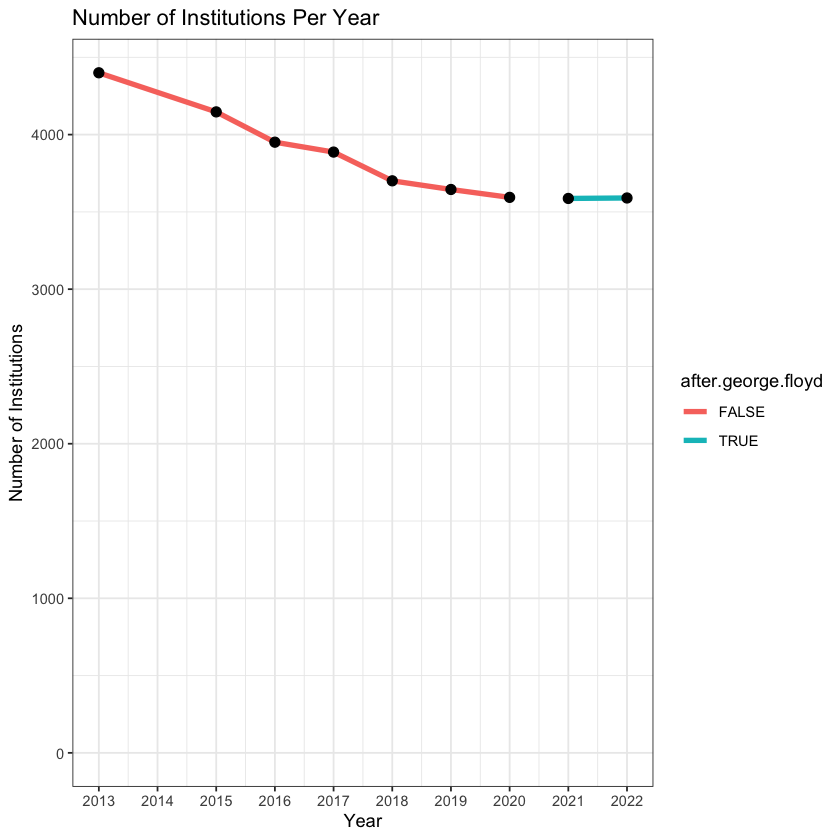

In [8]:
x_label = "Year"
y_label = "Number of Institutions"

summary(year.df$num_institutions)

ggplot(confident.year.df, aes(year, num_institutions, color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$num_institutions)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))


### Plot of tenured and tenure track faculty per year

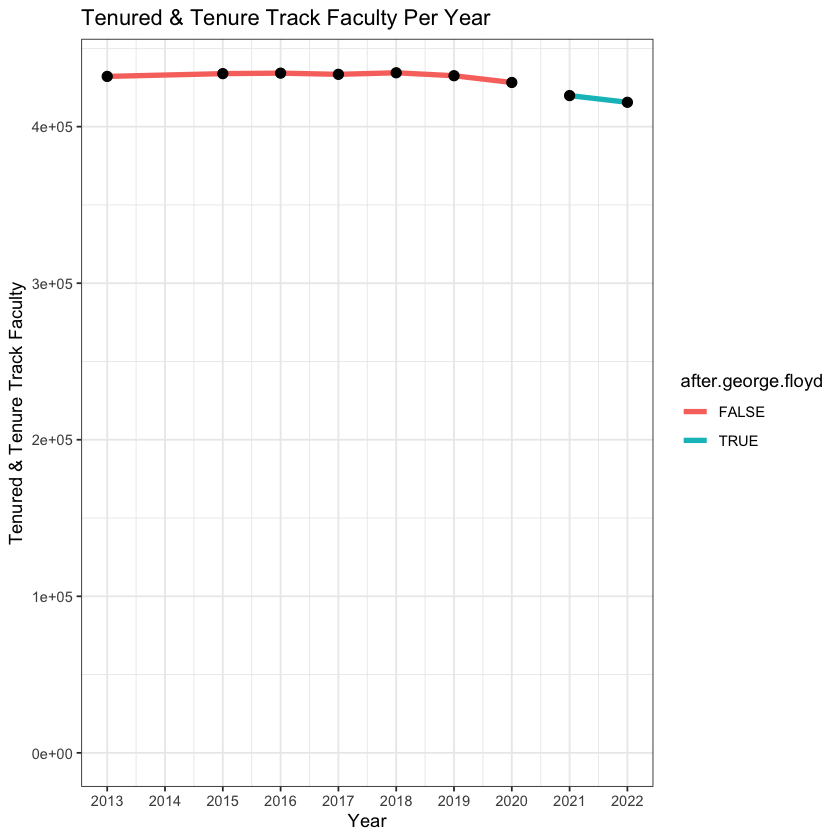

In [9]:
x_label = "Year"
y_label = "Tenured & Tenure Track Faculty"

#summary(confident.year.df$tenure_track_Grand_total_sum)

ggplot(confident.year.df, aes(year, tenure_track_Grand_total_sum, color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$tenure_track_Grand_total_sum)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))

### Tenured Faculty Per Year

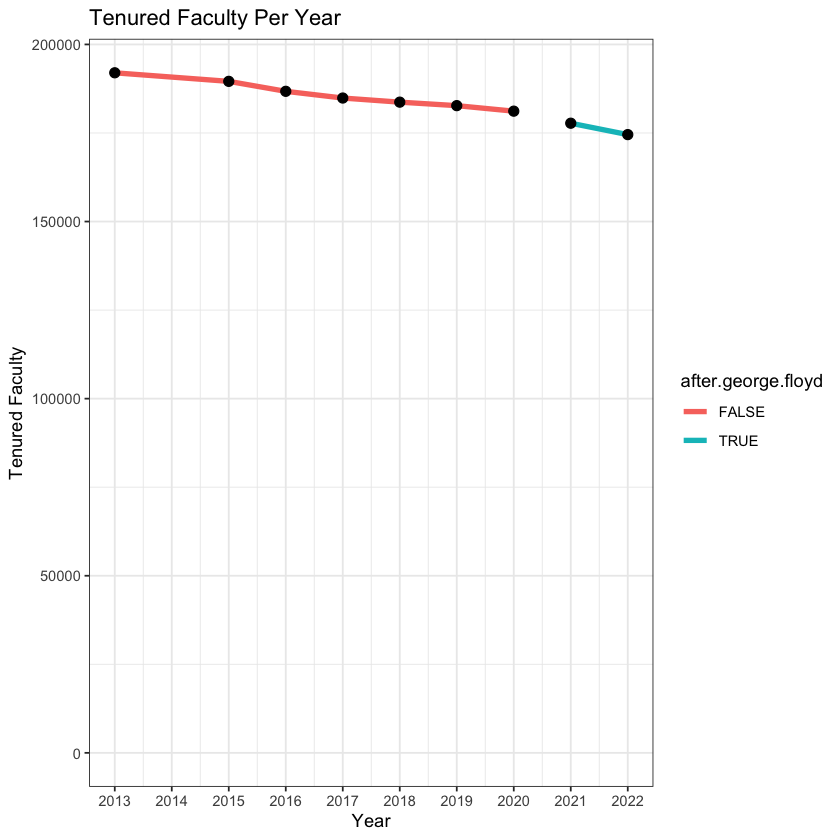

In [10]:
x_label = "Year"
y_label = "Tenured Faculty"

#summary(confident.year.df$tenure_track_Grand_total_sum)

ggplot(confident.year.df, aes(year, tenured_Grand_total_men_sum, color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$tenured_Grand_total_men_sum)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))

### Tenure Track Faculty Per Year

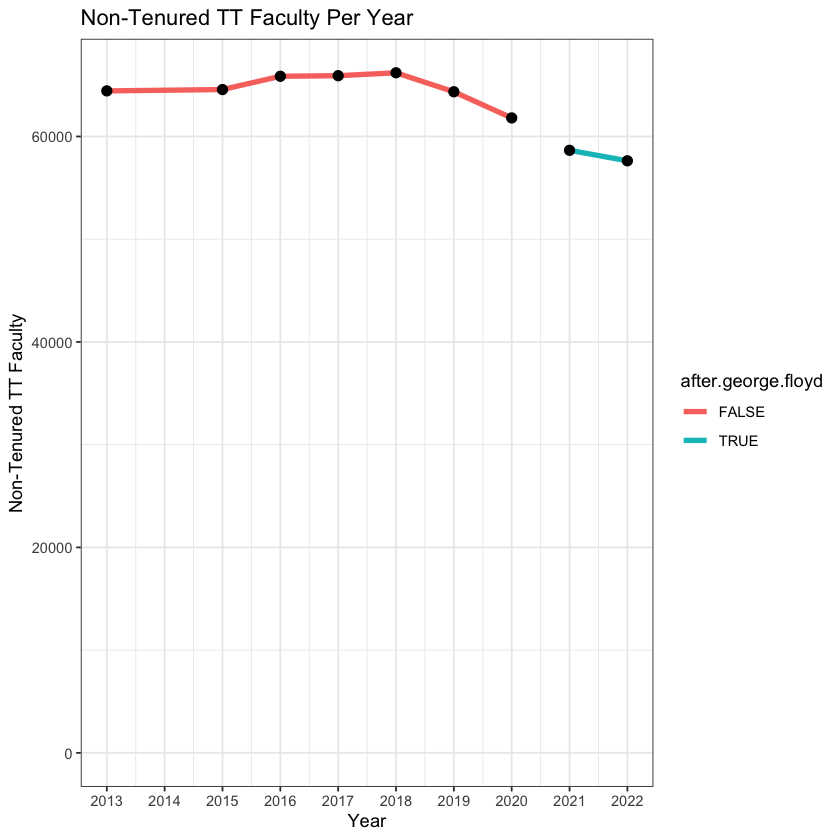

In [11]:
x_label = "Year"
y_label = "Non-Tenured TT Faculty"

#summary(confident.year.df$tenure_track_Grand_total_sum)

ggplot(confident.year.df, aes(year, un_tenured_Grand_total_men_sum, color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$un_tenured_Grand_total_men_sum)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))

### Plot of faculty per institution per year

In [12]:
confident.year.df$tenure_track_Grand_total_per_institution <- 
    confident.year.df$tenure_track_Grand_total_sum / 
    confident.year.df$num_institutions

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   98.2   109.9   115.8   112.5   117.4   119.1 

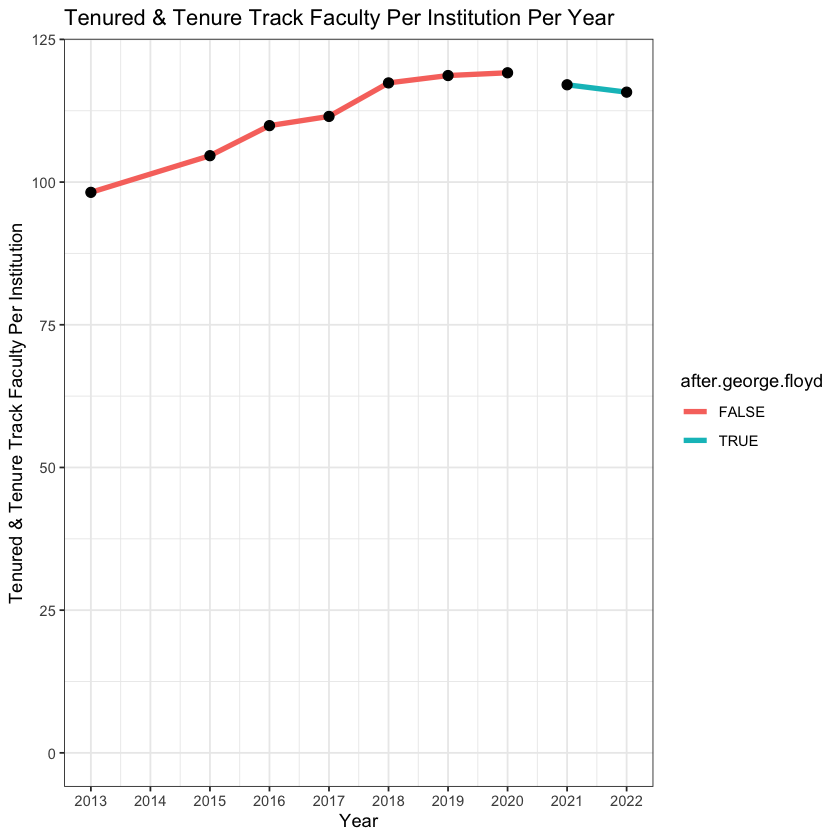

In [13]:
x_label = "Year"
y_label = "Tenured & Tenure Track Faculty Per Institution"

summary(confident.year.df$tenure_track_Grand_total_per_institution)

ggplot(confident.year.df, aes(year, tenure_track_Grand_total_per_institution, color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$tenure_track_Grand_total_per_institution)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))

### Plot Sum URM TT Faculty Per Year

,year,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum
,<int>,<int>
1,2016,52533
2,2017,53564
3,2018,54400
4,2019,54968
5,2020,55668
6,2021,56321
7,2022,57159
8,2013,49294
10,2015,51177


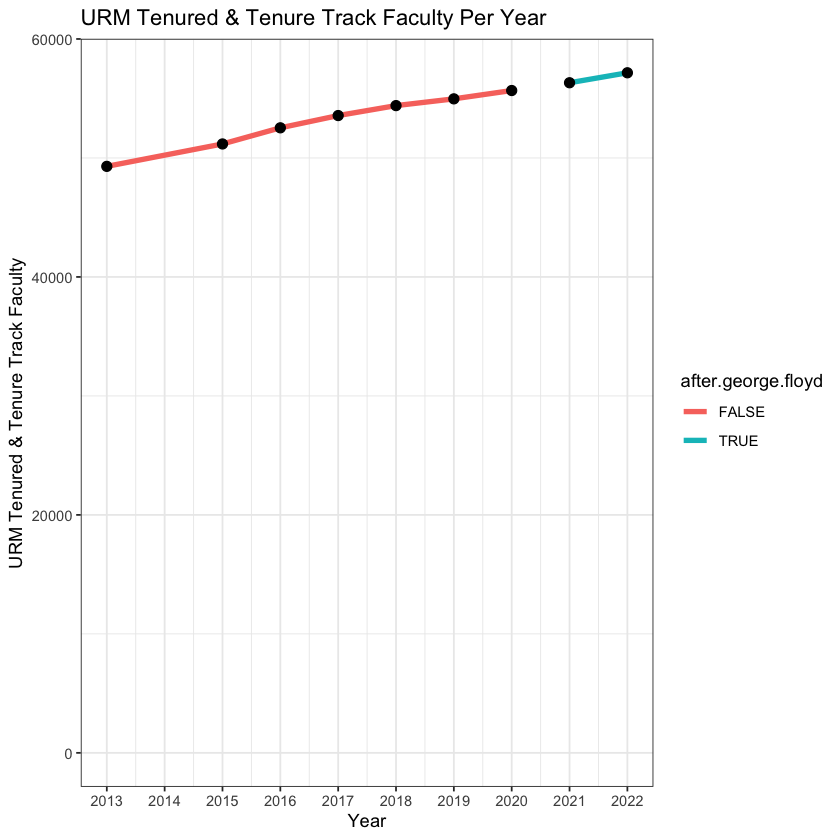

In [14]:
confident.year.df[c("year", "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum")]

x_label = "Year"
y_label = "URM Tenured & Tenure Track Faculty"

ggplot(confident.year.df, aes(year, tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum, 
                              color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_sum)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))

### Plot PCT URM TT Faculty Per Year

,year,tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct
,<int>,<dbl>
1,2016,0.1209944
2,2017,0.1235848
3,2018,0.1252282
4,2019,0.1270839
5,2020,0.1299986
6,2021,0.1341465
7,2022,0.1375459
8,2013,0.1140835
10,2015,0.1179558


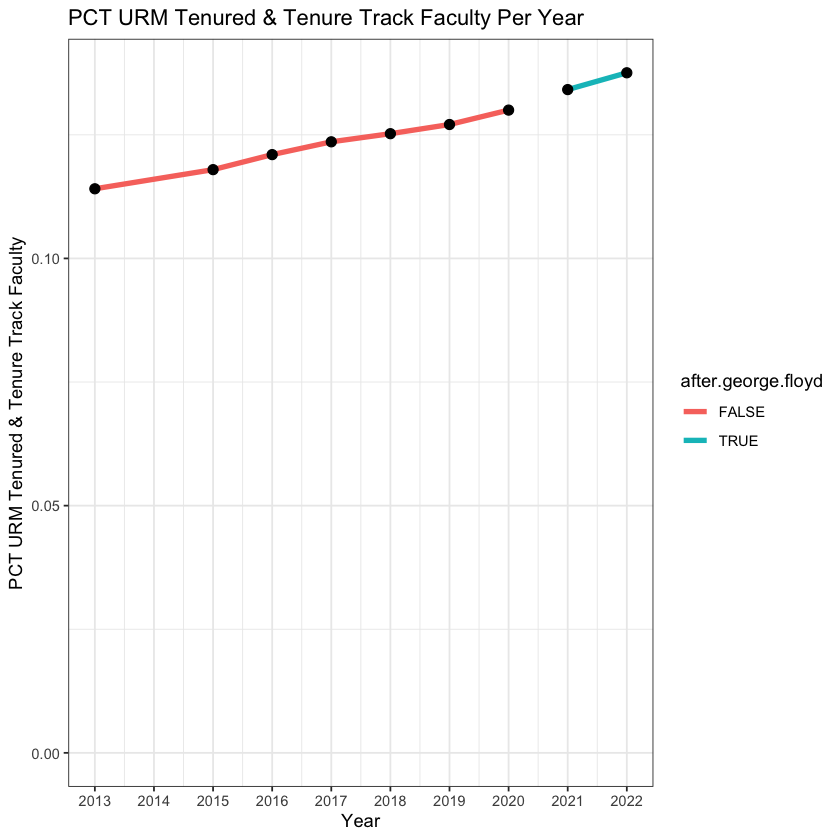

In [15]:
confident.year.df[c("year", "tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct")]

x_label = "Year"
y_label = "PCT URM Tenured & Tenure Track Faculty"

ggplot(confident.year.df, aes(year, tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct, 
                              color=after.george.floyd)) +
    geom_line(size=1.5) +
    geom_point(size=2.5, color="black") +
    ylim(0,max(confident.year.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct)) +
    scale_x_continuous(breaks=seq(0,max(confident.year.df$year),1)) +
    theme_bw() +
    xlab(x_label) +
    ylab(y_label) +
    ggtitle(paste(y_label,"Per", x_label))

## Analysis of period after the death of George Floyd
TODO: don't forget to adjust for autocorrelation

### Overall Linear Model and Plot

In [88]:
summary(lm.1 <- lm(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~
           year + after.george.floyd, data=confident.year.df))


Call:
lm(formula = tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~ 
    year + after.george.floyd, data = confident.year.df)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0005606 -0.0005024  0.0001339  0.0002431  0.0005606 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -4.472e+00  1.734e-01 -25.794 2.24e-07 ***
year                    2.278e-03  8.597e-05  26.502 1.91e-07 ***
after.george.floydTRUE  2.564e-03  5.721e-04   4.482  0.00418 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0005112 on 6 degrees of freedom
Multiple R-squared:  0.9965,	Adjusted R-squared:  0.9954 
F-statistic: 865.2 on 2 and 6 DF,  p-value: 4.125e-08


In [89]:
## not a better fit, so we don't do the interaction
summary(lm.2 <- lm(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~
           year + after.george.floyd + year:after.george.floyd, data=confident.year.df))


Call:
lm(formula = tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~ 
    year + after.george.floyd + year:after.george.floyd, data = confident.year.df)

Residuals:
         1          2          3          4          5          6          7 
 2.293e-04  5.574e-04 -6.144e-05 -4.679e-04  1.845e-04  3.212e-17 -3.201e-17 
         8         10 
 1.052e-04 -5.471e-04 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -4.440e+00  1.474e-01 -30.129 7.56e-07 ***
year                         2.262e-03  7.307e-05  30.962 6.60e-07 ***
after.george.floydTRUE      -2.296e+00  1.242e+00  -1.849    0.124    
year:after.george.floydTRUE  1.137e-03  6.144e-04   1.851    0.123    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0004314 on 5 degrees of freedom
Multiple R-squared:  0.9979,	Adjusted R-squared:  0.9967 
F-statistic: 811.2 on 3 and 5 

In [90]:
lm.1.sim.df

,year,after.george.floyd,fit,lwr,upr
,<int>,<lgl>,<dbl>,<dbl>,<dbl>
1,2013,FALSE,0.1135450,0.1126394,0.1144506
2,2014,FALSE,0.1158894,0.1151546,0.1166241
3,2015,FALSE,0.1182337,0.1176395,0.1188279
4,2016,FALSE,0.1205781,0.1200684,0.1210877
5,2017,FALSE,0.1229224,0.1224128,0.1234320
6,2018,FALSE,0.1252667,0.1246725,0.1258610
7,2019,FALSE,0.1276111,0.1268763,0.1283459
8,2020,FALSE,0.1299554,0.1290499,0.1308610
9,2021,TRUE,0.1346740,0.1336721,0.1356760


In [97]:
sort(confident.year.df$year)

[1] 2013 2015 2016 2017 2018 2019 2020 2021 2022

In [136]:
#sort(lm.1.sim.df$year)
#colnames(lm.1.sim.df)


[1] 2013 2015 2016 2017 2018 2019 2020 2021 2022

In [159]:
prettyNum(coef(summary(lm.2))['year',][['Estimate']]*100, digits=1)

[1] "0.2"

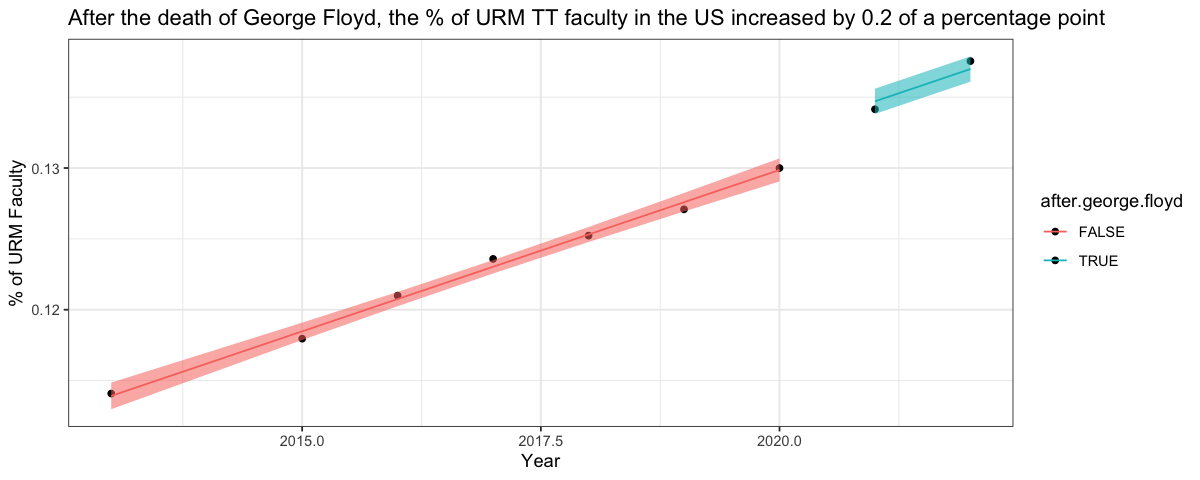

In [166]:
### now generate fitted predictions and illustrate

lm.1.sim.df <- data.frame(year=seq(2013,2022))
lm.1.sim.df$after.george.floyd <- lm.1.sim.df$year >=2021
lm.1.sim.df <- cbind(lm.1.sim.df, predict(lm.1, lm.1.sim.df, interval="confidence"))
lm.1.sim.df <- subset(lm.1.sim.df, year!=2014)

sorted.year.df <- confident.year.df[order(confident.year.df$year),]

lm.1.sim.df <- cbind(lm.1.sim.df, sorted.year.df[c("tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct")])


options(repr.plot.width=10, repr.plot.height=4)
ggplot(lm.1.sim.df, aes(year, tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct, fill=after.george.floyd)) +
    geom_point() +
    geom_ribbon(aes(ymax=upr, ymin=lwr, fill=after.george.floyd, alpha=0.5), show.legend=FALSE) +
    geom_line(aes(y=fit, color=after.george.floyd)) +
    theme_bw() +
    ggtitle(paste("After the death of George Floyd, the % of URM TT faculty in the US increased by",
                 prettyNum(coef(summary(lm.2))['year',][['Estimate']]*100, digits=1), "of a percentage point")) +
    xlab("Year") +
    ylab("% of URM Faculty")


### Set up Within-Institution Multi-Level Modeling

In [167]:
#confident.unis.df <- subset(confident.all.df, is.na(usnews_category)!=TRUE & tenured_un_tenured_Grand_total>0)

## add an integer measure, zeroed at the earliest year
confident.all.df$year.int <- confident.all.df$year - min(confident.all.df$year)
confident.unis.df <- subset(confident.all.df, tenured_un_tenured_Grand_total>0)

print(paste(nrow(confident.unis.df), "total eligible rows"))
print(paste(length(unique(subset(confident.unis.df)$INSTNM)), "total eligible institutions"))

[1] "35186 total eligible rows"
[1] "2484 total eligible institutions"


In [168]:
#summary(confident.unis.df$tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_total)

In [169]:
# ggplot(confident.unis.df, aes(reorder(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct,value),
#                              INSTNM)) +
#     geom_boxplot()

In [170]:
#confident.unis.df$hsi_hbcu_tribal
summary(confident.unis.df$year)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2004    2009    2013    2013    2018    2022 

In [171]:
summary(lme.year <- lmer(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~
             year.int + (1|INSTNM), data=confident.unis.df))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~  
    year.int + (1 | INSTNM)
   Data: confident.unis.df

REML criterion at convergence: -77946.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.5987  -0.3138   0.0088   0.3044  11.1013 

Random effects:
 Groups   Name        Variance Std.Dev.
 INSTNM   (Intercept) 0.011383 0.10669 
 Residual             0.005028 0.07091 
Number of obs: 35186, groups:  INSTNM, 2484

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 3.890e-03  2.280e-03 2.796e+03   1.706   0.0882 .  
year.int    7.073e-03  7.049e-05 3.297e+04 100.345   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
year.int -0.277

In [172]:
#confident.unis.df$hsi_hbcu_tribal

In [174]:
summary(lme.year.min <- lmer(tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~
             year.int + after.george.floyd + year.int:after.george.floyd + (1|INSTNM) + (1|hsi_hbcu_tribal), data=confident.unis.df))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
tenured_un_tenured_black_latino_american_indian_alaska_native_hawaiian_pacific_multiracial_pct ~  
    year.int + after.george.floyd + year.int:after.george.floyd +  
        (1 | INSTNM) + (1 | hsi_hbcu_tribal)
   Data: confident.unis.df

REML criterion at convergence: -77060.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.7324  -0.3250   0.0028   0.3124  11.2062 

Random effects:
 Groups          Name        Variance Std.Dev.
 INSTNM          (Intercept) 0.010449 0.10222 
 hsi_hbcu_tribal (Intercept) 0.003412 0.05841 
 Residual                    0.004924 0.07017 
Number of obs: 34317, groups:  INSTNM, 2298; hsi_hbcu_tribal, 2

Fixed effects:
                                  Estimate Std. Error         df t value
(Intercept)                      3.079e-02  4.144e-02  1.000e+00   0.743
year.int                         7.800e-03  8.288e-05  3.213e+04  94.106
after.ge